In [1]:
import importlib.util

In [2]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
import backtrader as bt
from datetime import datetime

In [3]:
spec = importlib.util.spec_from_file_location("PandasRepo", "/Users/dennis/PycharmProjects/IbTrader/PandasRepo.py")
PandasRepoModule = importlib.util.module_from_spec(spec)
spec.loader.exec_module(PandasRepoModule)

In [4]:
class SectorRotationStrategy(bt.Strategy):

    def __init__(self,
                 fastSmaDays = 40,
                 slowSmaDays = 200):
        self.maxNumPositions = 6
        self.momentum = dict()
        for symbol in self.getdatanames():
            data = self.getdatabyname(symbol)
            smaFast = bt.ind.SMA(data, period=fastSmaDays)
            smaSlow = bt.ind.SMA(data, period=slowSmaDays)
            self.momentum[symbol] = smaFast/smaSlow

    def next(self):
        momentums = dict()
        for symbol in self.getdatanames():
            momentums[symbol] = self.momentum[symbol][0]

        buyThreshold = sorted(momentums.values())[-min(self.maxNumPositions, len(momentums))]
        symbolsToBuy = {k: v for k, v in momentums.items() if v >= buyThreshold}
        pct = 1.0 / len(symbolsToBuy)

        for symbol in self.getdatanames():
            if symbol in symbolsToBuy:
                self.order_target_percent(data=self.getdatabyname(symbol), target=pct)
            else:
                self.order_target_percent(data=self.getdatabyname(symbol), target=0)

In [7]:
class BacktraderWrapper:
    def __init__(self,
                 startCash = 10000,
                 universe = ["IYM", "IYC", "IYK", "IYE", "IYF", "IYH", "IYR", "IYW", "IDU"],
                 startDate = datetime(2016, 1, 1),
                 endDate = datetime(2017, 12, 31)):
        self._startCash = startCash
        self._universe = universe
        self._startDate = startDate
        self._endDate = endDate

    def RunBackTest(self):
        # Create an instance of cerebro
        cerebro = bt.Cerebro()

        # Add our strategy
        cerebro.addstrategy(SectorRotationStrategy)

        # Add data feed
        for symbol in self._universe:
            df = PandasRepoModule.PandasRepo().GetData(symbol, self._startDate, self._endDate)
            data = bt.feeds.PandasData(dataname=df)
            cerebro.adddata(data, name=symbol)

        # Set our desired cash start
        cerebro.broker.setcash(self._startCash)

        # Set up pyfolio
        cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

        # Run over everything
        results = cerebro.run()
        strat = results[0]
        pyfoliozer = strat.analyzers.getbyname('pyfolio')
        returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
        
        benchmarkDf = df = PandasRepoModule.PandasRepo().GetData('SPY', self._startDate, self._endDate)
        benchmarkDf = benchmarkDf['Close'].pct_change().fillna(0).tz_localize(tz='UTC')
        benchmarkDf.index.name = 'index'
        
        import matplotlib.pyplot as plt
        plt.plot(returns)
        plt.show()
        
        plt.plot(benchmarkDf)
        plt.show()

        import pyfolio as pf
        pf.create_full_tear_sheet(
            returns,
            positions=positions,
            benchmark_rets = benchmarkDf,
            transactions=transactions,
            gross_lev=gross_lev,
            round_trips=True)

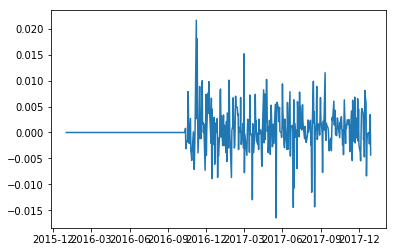

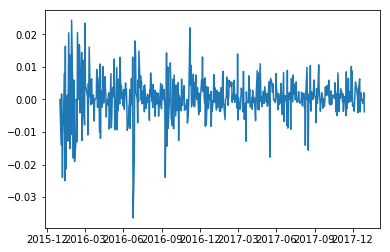

Entire data start date: 2016-01-01
Entire data end date: 2017-12-29


Backtest Months: 24


Performance statistics,Backtest
annual_return,0.10
annual_volatility,0.06
sharpe_ratio,1.77
calmar_ratio,3.25
stability_of_timeseries,0.95
max_drawdown,-0.03
omega_ratio,1.50
sortino_ratio,2.86
skew,0.43
kurtosis,6.36


/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/pyfolio/timeseries.py:416: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  beta, alpha = sp.stats.linregress(factor_returns.loc[ret_index].values,
/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


Worst Drawdown Periods,net drawdown in %,peak date,valley date,recovery date,duration
0,3.20,2016-10-24,2016-11-03,2016-11-09,13
1,3.17,2017-03-01,2017-04-13,2017-05-24,61
2,2.52,2017-06-19,2017-07-06,2017-07-20,24
3,2.21,2016-12-13,2016-12-30,2017-01-25,32
4,1.50,2017-08-16,2017-08-18,2017-08-31,12




[-0.007 -0.015]


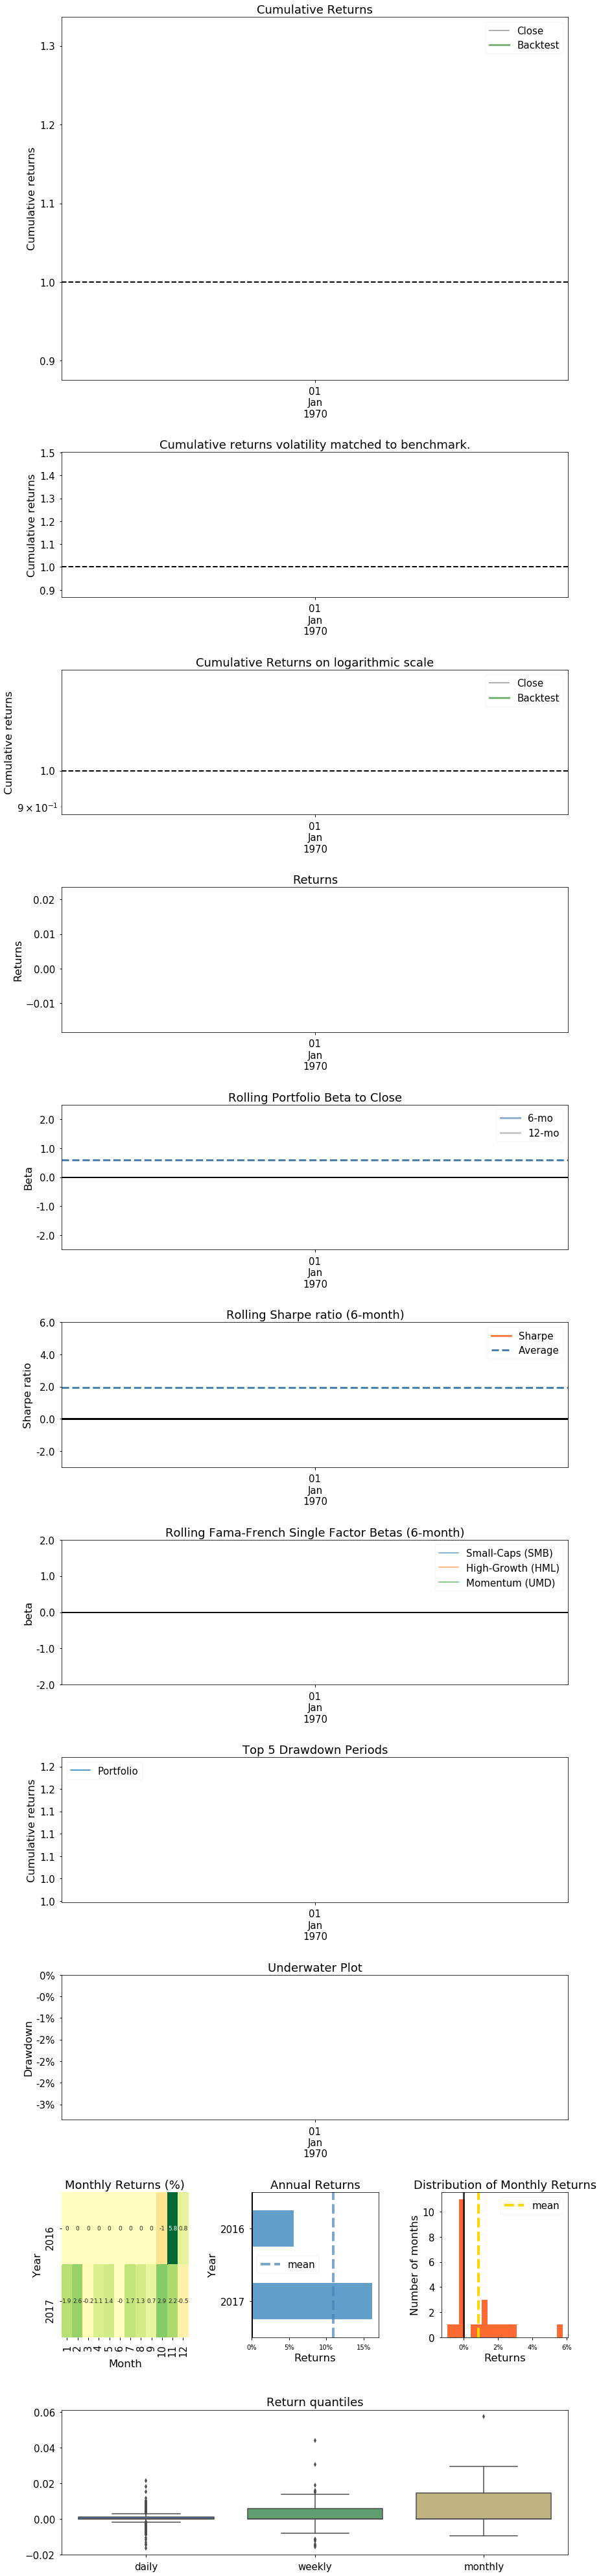

Stress Events,mean,min,max
New Normal,0.04%,-1.65%,2.16%


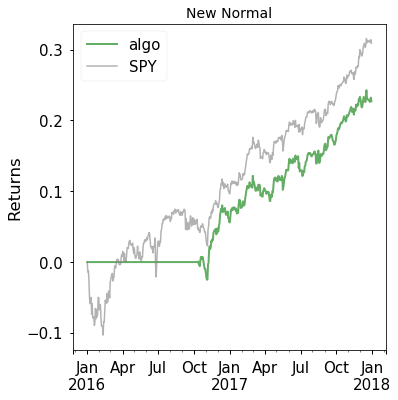

Top 10 long positions of all time,max
IDU,99.98%


Top 10 short positions of all time,max


Top 10 positions of all time,max
IDU,99.98%


All positions ever held,max
IDU,99.98%


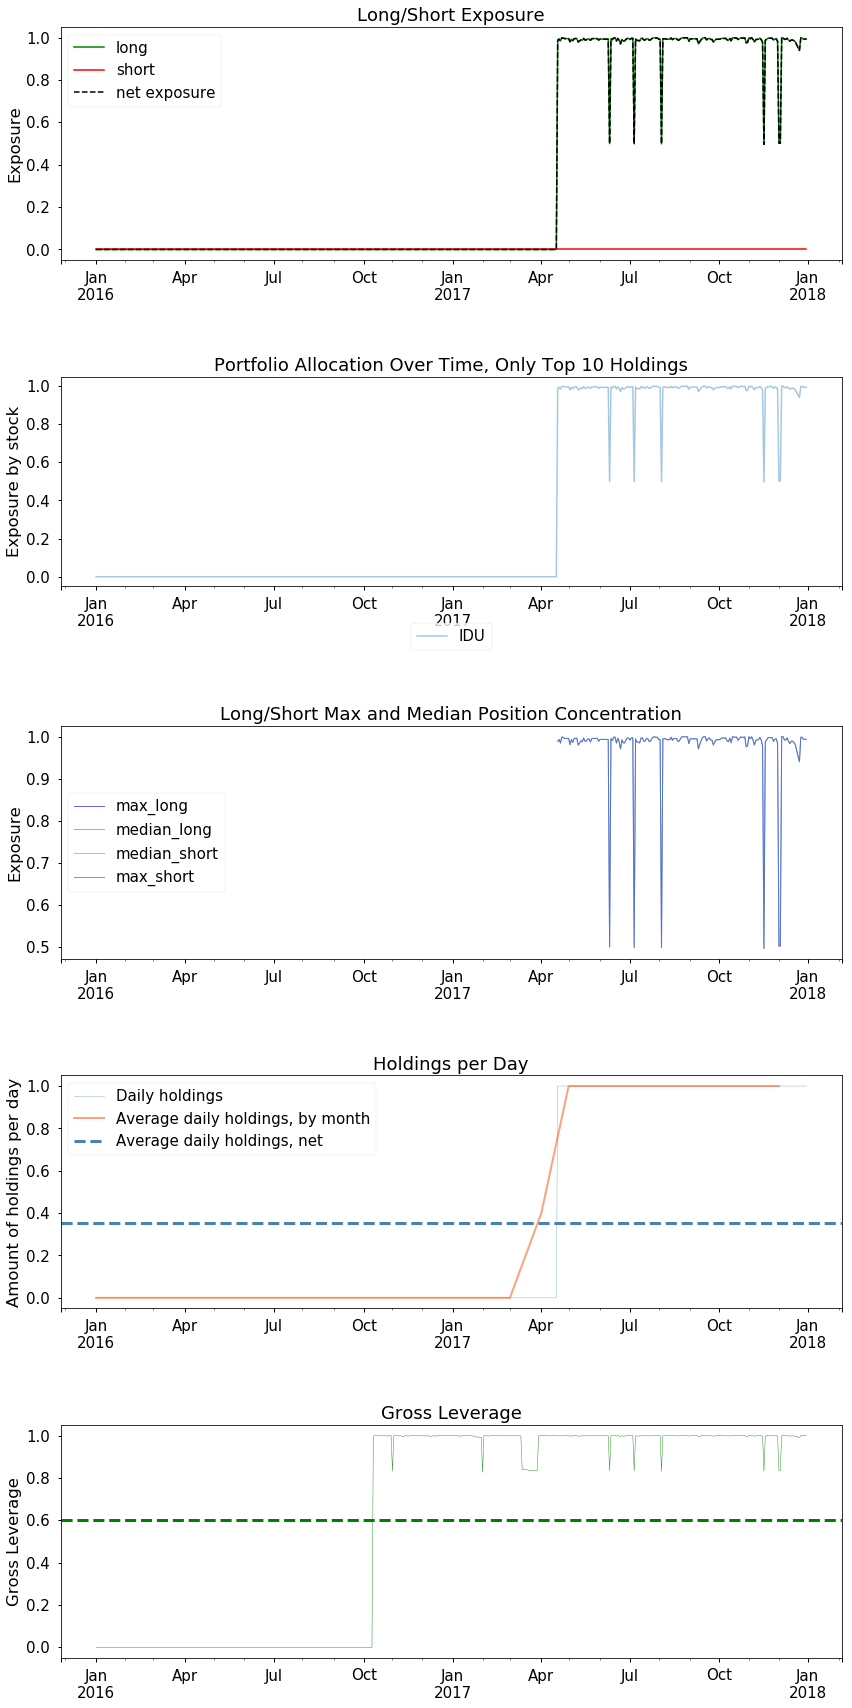

/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/pyfolio/plotting.py:1210: FutureWarning: 
.resample() is now a deferred operation
You called plot(...) on this deferred object which materialized it into a series
by implicitly taking the mean.  Use .resample(...).mean() instead
  **kwargs)
/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


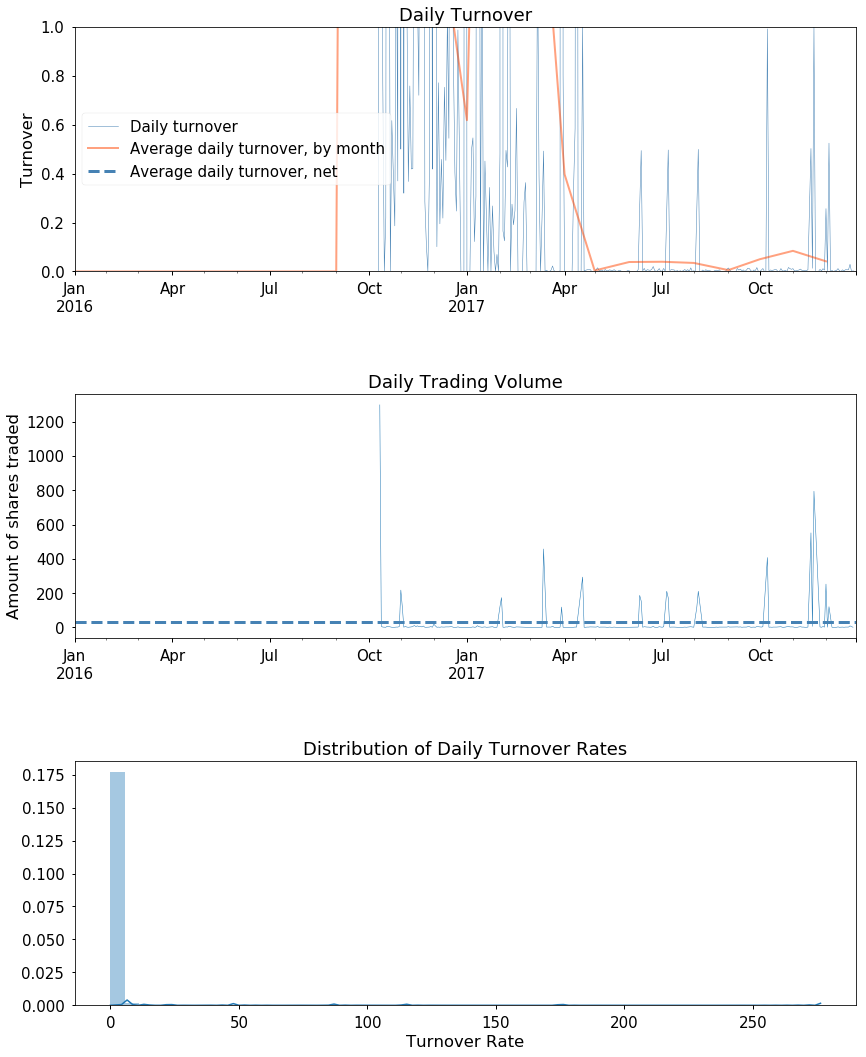

/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/pyfolio/round_trips.py:73: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  .agg(stats_dict)
/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/pyfolio/round_trips.py:76: FutureWarning: Using 'rename_axis' to alter labels is deprecated. Use '.rename' instead
  axis='columns'))
/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/pyfolio/round_trips.py:79: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  .agg(stats_dict)
/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/pyfolio/round_trips.py:83: FutureWarning: Using 'rename_axis' to alter labels is deprecated. Use '.rename' instead
  axis='columns'))
/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/pyfolio/round_trips.py:372: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future 

Summary stats,All trades,Long trades
Total number of round_trips,201.00,201.00
Percent profitable,0.94,0.94
Winning round_trips,189.00,189.00
Losing round_trips,12.00,12.00
Even round_trips,0.00,0.00


PnL stats,All trades,Long trades
Total profit,$11473.75,$11473.75
Gross profit,$12245.61,$12245.61
Gross loss,$-771.86,$-771.86
Profit factor,$15.87,$15.87
Avg. trade net profit,$57.08,$57.08
Avg. winning trade,$64.79,$64.79
Avg. losing trade,$-64.32,$-64.32
Ratio Avg. Win:Avg. Loss,$1.01,$1.01
Largest winning trade,$2956.11,$2956.11
Largest losing trade,$-498.50,$-498.50


Duration stats,All trades,Long trades
Avg duration,119 days 11:34:55.527363,119 days 11:34:55.527363
Median duration,90 days 00:00:00,90 days 00:00:00
Avg # round_trips per day,0.46,0.46
Avg # round_trips per month,9.73,9.73


Return stats,All trades,Long trades
Avg returns all round_trips,2.27%,2.27%
Avg returns winning,2.65%,2.65%
Avg returns losing,-3.57%,-3.57%
Median returns all round_trips,0.13%,0.13%
Median returns winning,0.14%,0.14%
Median returns losing,-0.65%,-0.65%
Largest winning trade,102.91%,102.91%
Largest losing trade,-30.53%,-30.53%


Symbol stats,IDU,IYC,IYE,IYF,IYH,IYK,IYM,IYR,IYW
Avg returns all round_trips,0.03%,3.81%,3.17%,4.19%,0.12%,1.67%,3.67%,0.34%,0.88%
Avg returns winning,0.03%,3.81%,5.78%,4.19%,0.33%,2.04%,3.97%,0.46%,0.88%
Avg returns losing,-0.00%,nan%,-11.59%,nan%,-1.52%,-0.88%,-1.27%,-0.19%,nan%
Median returns all round_trips,0.03%,2.78%,1.60%,0.10%,0.10%,1.85%,0.07%,0.01%,0.21%
Median returns winning,0.03%,2.78%,3.76%,0.10%,0.10%,2.06%,0.08%,0.02%,0.21%
Median returns losing,-0.00%,nan%,-2.79%,nan%,-1.52%,-0.88%,-0.00%,-0.19%,nan%
Largest winning trade,0.12%,9.23%,32.25%,46.57%,1.98%,4.92%,102.91%,1.15%,8.75%
Largest losing trade,-0.00%,0.01%,-30.53%,0.01%,-2.61%,-0.88%,-3.82%,-0.29%,0.04%


Profitability (PnL / PnL total) per name,pnl
symbol,
IYF,0.28%
IYM,0.25%
IYC,0.24%
IYW,0.09%
IYK,0.06%
IDU,0.04%
IYR,0.03%
IYH,0.03%
IYE,-0.03%


<Figure size 1008x1296 with 0 Axes>

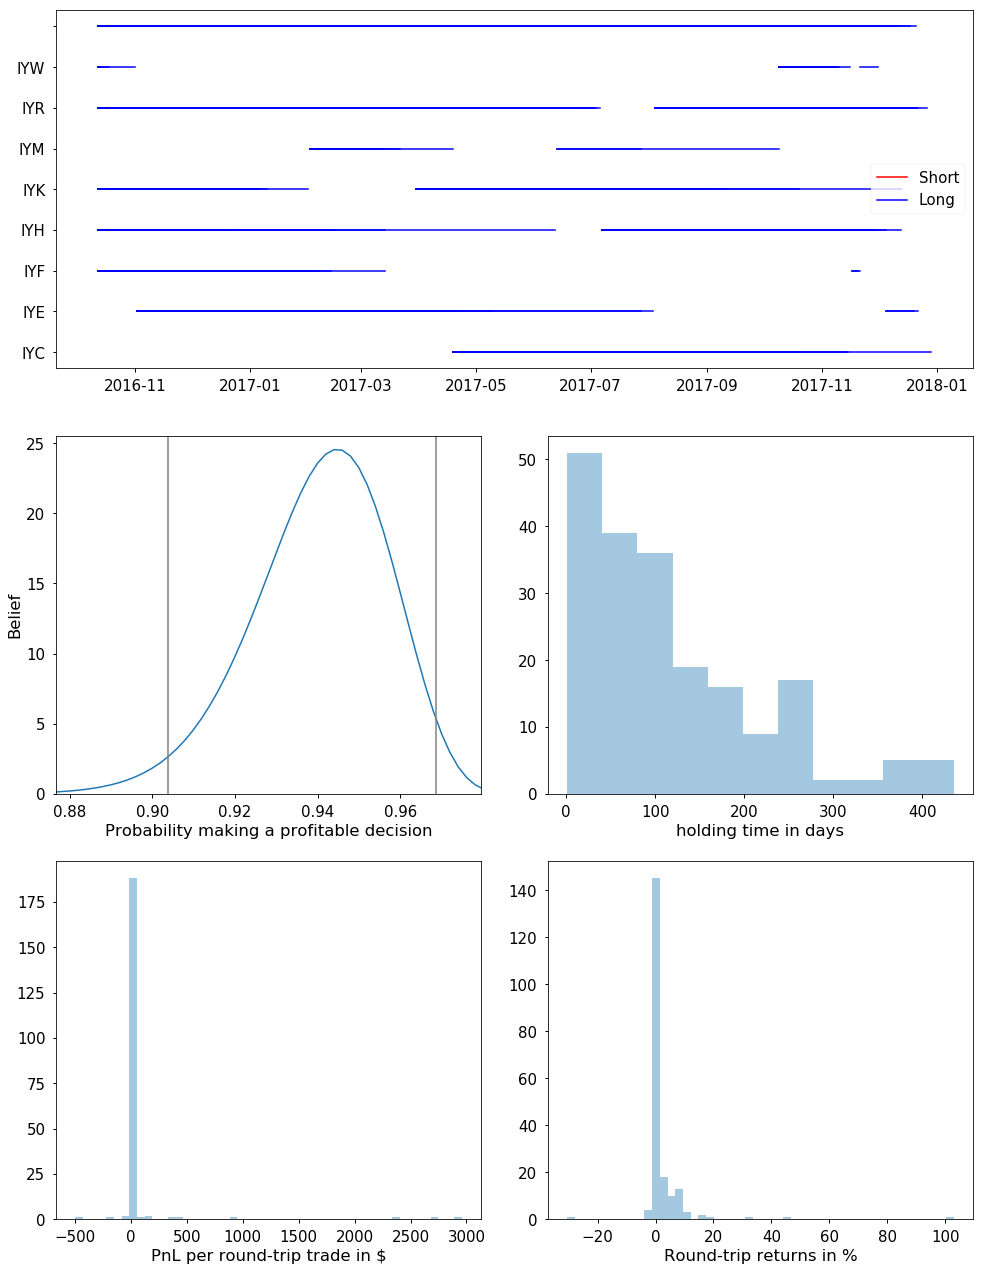

In [8]:
BacktraderWrapper(startCash=100000).RunBackTest()